In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
# #變更路徑
# %cd drive/MyDrive/Colab_Notebooks/competition2021_04-07_release/

/content/drive/MyDrive/Colab_Notebooks/competition2021_04-07_release


In [37]:
!nvidia-smi

Mon Aug 16 23:35:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    36W / 250W |  11491MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# info : https://blog.csdn.net/qq_40214464/article/details/116918552
# 將訓練資料放在drive內，讀取太慢導致訓練低下(每次都需讀取google drive)
# !!!!!!重點!!!!!!!! 斷線後會被清空.....所以資料必須重新複製
# 將其複製工作目錄下
# step1 在/content 底下建立資料夾
# !mkdir competition20210407
# !mkdir competition20210407/ImageDataset
# step2 將drive的訓練資料複製到底下
# %cp -av /content/drive/MyDrive/Colab_Notebooks/competition2021_04-07_release/ImageDataset/training_set.7z /content/competition20210407/ImageDataset
# %cp -av /content/drive/MyDrive/Colab_Notebooks/competition2021_04-07_release/ImageDataset/testing_set.7z /content/competition20210407/ImageDataset
# 刪除當前路徑下指定資料夾(非空資料夾)，假如建立錯誤
# %rm -rf train_data/
# step3 解壓縮
# !pip install pyunpack
# !pip install patool
# from pyunpack import Archive
# Archive('/content/competition20210407/ImageDataset/training_set.7z').extractall('/content/competition20210407/ImageDataset')
# Archive('/content/competition20210407/ImageDataset/testing_set.7z').extractall('/content/competition20210407/ImageDataset')

# 複製所需CSV檔
# %cp /content/drive/MyDrive/Colab_Notebooks/competition2021_04-07_release/basic_image_tab.csv /content/competition20210407
# %cp /content/drive/MyDrive/Colab_Notebooks/competition2021_04-07_release/basic_token.csv /content/competition20210407
# %cp /content/drive/MyDrive/Colab_Notebooks/competition2021_04-07_release/test_image0616_tab.csv /content/competition20210407
%cd competition20210407
!ls



/content/competition20210407
basic_image_tab.csv  ImageDataset	     test_image0616_tab.csv
basic_token.csv      test_image0615_tab.csv


In [ ]:
# 檢查數據

import os
print()
lst = os.listdir(os.getcwd() +'/ImageDataset/training_set')
print(len(lst))
print(os.listdir(os.getcwd() +'/ImageDataset/testing_set'))


68804
['test_stage_data_0615', 'test_stage_data_0616', 'test_stage_data_0617']


In [ ]:
import os
from os import listdir
import math
import sys

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.utils.data
import time
py_version = float((sys.version)[:3])
print(py_version)
print(time.strftime("%Y-%m-%d, %H:%M", time.localtime())) #12:14
print(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

3.7
2021-08-16, 11:57
cuda


In [30]:
### before start , please check image_table.csv
### Ref: https://chih-sheng-huang821.medium.com/03-pytorch-dataaug-a712a7a7f55e

# output [1] same shape
class MyDataset01(torch.utils.data.Dataset):
    def __init__(self, root, tab_file = 'basic_image_tab.csv', transform = None, train = True, scale = 0.8, 
                 IsAug = None, shape = (64, 64), pad_module = ['center', 'center'], test=False):
        super().__init__()
        '''
        parameter:
            root : .csv file root
            tab_file : image info. on csv
            transform : if not None , maybe using 
            train : using training set or validation set
            scale : numble of training set on dataset
            IsAug : Using Augumentation Data , only train == True
            shape : change Image size for what
            pad_module: padding direction , ex: set 'Center' padding/change size around image
            
            
            padding module used cut height if resize h < ground truth h ex: resize_h = 64 , 
            gt_h = 64 ,cut where? top or bottom, input [h_direction, w_direction] ,ex:[center, left]
        '''
        df = pd.read_csv(root + '/'+ tab_file , encoding = 'big5')
        imgs = df['img_name'].values.tolist()
        labels = df['img_token'].values.tolist()
        
        self.imgs = imgs
        self.labels = labels
        
        self.root = os.path.join(root, 'ImageDataset', 'training_set')
        if test != False:
            self.root = os.path.join(root, 'ImageDataset', 'testing_set', test)
        self.train = train
        self.transform = transform
        self.IsAug = IsAug
        self.height, self.width = shape
        self.pad_module = pad_module
        
        self.count = int(len(self.imgs)*scale)
    def __len__(self):
        if self.train == True:
            return self.count
        else :
            return len(self.imgs) - self.count
            
    
    def __getitem__(self, index):
        
        if self.IsAug != None :
            # only augumentation training_data
            if self.train == True:
                transform_toResize = torchvision.transforms.Resize((self.height, self.width))
                img_path = os.path.join(self.root , self.imgs[index])
                img = Image.open(img_path)
                img = transform_toResize(img)
                
                label = self.labels[index]
                
                if self.IsAug == 'Rotate90':
                    img = img.transpose(Image.ROTATE_90)
                elif self.IsAug == 'Rotate180':
                    img = img.transpose(Image.ROTATE_180)
                elif self.IsAug == 'Rotate270':
                    img = img.transpose(Image.ROTATE_270)
                elif self.IsAug == 'Rotate_pos_20':
                    img = img.rotate(-20) #順時
                elif self.IsAug == 'Rotate_neg_20':
                        img = img.rotate(20)
                else:
                    raise ValueError('>>If want to using Aug_Data, follow specified param. or new one')
            
                trans_toTensor = torchvision.transforms.ToTensor()
                img = trans_toTensor(img)
                
                return img, label
            else:
                raise ValueError('>>Get Dataset Error : If used Augumentation data, please check \'train=True\'. ')
        # ============
        else:
            
            if self.train == True:
                img_path = os.path.join(self.root , self.imgs[index])
                img = Image.open(img_path)
                label = self.labels[index]
            else:
                img_path = os.path.join(self.root , self.imgs[self.count+index])
                img = Image.open(img_path)
                label = self.labels[self.count+index]
                
            gt_height , gt_width = np.array(img).shape[0], np.array(img).shape[1] # ground truth
            
            if gt_width > self.width:
                transform_toResize = torchvision.transforms.Resize((self.height, self.width))
                img = transform_toResize(img)
            else:
                add_h = self.height - gt_height
                add_w = self.width - gt_width
                
                # padding = (add_left, add_top, add_right, add_bottom)
                if self.pad_module[0] == 'center':
                    if add_h % 2 == 0:
                        add_top = add_h//2
                        add_bottom = add_h//2
                    else:
                        add_top = add_h//2
                        add_bottom = add_h//2 + 1
                elif self.pad_module[0] == 'top':
                    add_top = add_h
                else:
                    add_bottom = add_h
                    
                if self.pad_module[1] == 'center':
                    if add_w % 2 == 0:
                        add_left = add_w//2
                        add_right = add_w//2
                    else:
                        add_left = add_w//2
                        add_right = add_w//2+1
                elif self.pad_module[1] == 'left':
                    add_left = add_w
                else:
                    add_right = add_w
                    
                padding = (add_left, add_top, add_right, add_bottom)
                trans_pad = torchvision.transforms.Pad(padding, fill = 0, padding_mode="constant")
                img = trans_pad(img)
            trans_toTensor = torchvision.transforms.ToTensor()
            img = trans_toTensor(img)
            
            return img, label
        
if __name__ == '__main__':
    
    root = os.getcwd()

    train_data = MyDataset01(root)
    print('train_data :', len(train_data))
    valid_data = MyDataset01(root, train = False)
    print('valid_data :', len(valid_data))
    test_data = MyDataset01(root, tab_file = 'test_image0615_tab.csv', scale = 1, test = 'test_stage_data_0615')
    print('test_data :', len(test_data))
    test_data = MyDataset01(root, tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
    print('test_data :', len(test_data))

train_data : 55043
valid_data : 13761
test_data : 2000
test_data : 7016


55043
7016


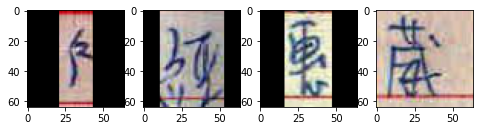

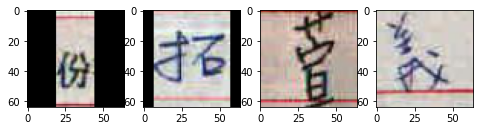

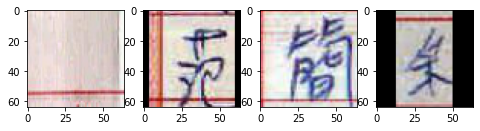

In [ ]:
# output [2] different shape
class MyDataset02(torch.utils.data.Dataset):
    def __init__(self, root, tab_file = 'basic_image_tab.csv', transforms = None, train = True, scale = 0.8, test=False):
        super().__init__()
        '''
        
        '''
        df = pd.read_csv(root + '/'+ tab_file , encoding = 'big5')
        img_lst = df['img_name'].values.tolist()
        label_lst = df['img_token'].values.tolist()
        
        self.root = os.path.join(root, 'ImageDataset', 'training_set')
        if test != False:
            self.root = os.path.join(root, 'ImageDataset', 'testing_set', test)
        self.transforms = transforms
        self.train = train
        
        self.imgs = img_lst
        self.labels = label_lst
        self.count = int(len(self.imgs)*scale)
        
        
    def __len__(self):
        if self.train == True:
            return self.count
        else :
            return len(self.imgs) - self.count
        
    def __getitem__(self, index):
        
        if self.train == True:
            img_path = os.path.join(self.root , self.imgs[index])
            img = Image.open(img_path)
            label = self.labels[index]
        else:
            img_path = os.path.join(self.root , self.imgs[self.count+index])
            img = Image.open(img_path)
            label = self.labels[self.count+index]
            
        if self.transforms != None:
            img = self.transforms(img)
            
        return img, label
    # !!!!!!!!!!!!!!!!!! 透過自定義(custom)方式做batch
    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))

def Batch_Image_Data(data, resize_shape = (64, 64)):
    
    for index in range(len(data)):
        img = data[index].unsqueeze(0) # b, c, h, w == [1, 3, h, w]
        scale_f = resize_shape[0]/(img.size()[2])
        
        if resize_shape[1] > img.size()[3]:
            if img.size()[3] * scale_f < 1:
                resize_data = nn.functional.interpolate(img, resize_shape, mode = 'bilinear', align_corners=True)
               
            else:
                
            
                # python 3.7 ,set recompute_scale_factor=True
                if py_version == 3.7:
                    img = nn.functional.interpolate(img, scale_factor = scale_f, mode = 'bilinear', align_corners=True ,recompute_scale_factor=True)
                else:
                    img = nn.functional.interpolate(img, scale_factor = scale_f, mode = 'bilinear', align_corners=True)
                scale_width = img.size()[3]
                pad_width = resize_shape[1] - scale_width
                if pad_width % 2 ==0:
                    padding = (pad_width//2, 0, pad_width//2, 0)# left, top, right, botton
                else:
                    padding = (pad_width//2, 0, pad_width//2+1, 0)# left, top, right, botton

                data_transforms_pad = torchvision.transforms.Compose([
                    torchvision.transforms.Pad(padding, fill = 0, padding_mode="constant"),
                    torchvision.transforms.ToTensor()
                ])
                data_transforms_toImage = torchvision.transforms.ToPILImage()
                scale_image = data_transforms_toImage(img.squeeze(0))
                resize_data = data_transforms_pad(scale_image).unsqueeze(0)
        else:
            resize_data = nn.functional.interpolate(img, resize_shape, mode = 'bilinear', align_corners=True)
            
        if index == 0 :
            out = resize_data
        else:
            out = torch.cat([out, resize_data], dim = 0)
            
    return out
    

if __name__ == '__main__':
    data_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    train_data_set = MyDataset02(root = os.getcwd(), transforms = data_transform)
    test_data_set = MyDataset02(root = os.getcwd(), transforms = data_transform, 
                                tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
    print(len(train_data_set))
    print(len(test_data_set))
    data_loader = torch.utils.data.DataLoader(dataset = train_data_set,
                                             batch_size = 4,
                                             shuffle = False,
                                             collate_fn = train_data_set.collate_fn) 
    for i, (data, label) in enumerate(data_loader):
        
        data = Batch_Image_Data(data, resize_shape = (64, 64))# !!!!
#         label = torch.from_numpy(np.array(label))
        index = 0
        plt.figure(figsize =(8,4))
        for sample in data:
            
            plt.subplot(1, 4, index+1)
            plt.imshow(torchvision.transforms.ToPILImage()(sample))
            index += 1
        if i == 2:
            break    

In [ ]:
# get model
# weight Standardization Conv.
# ref: https://github.com/joe-siyuan-qiao/WeightStandardization
class WS_Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1,
                padding = 0, dilation =1, groups =1, bias = True):
        
        super(WS_Conv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                                       padding, dilation, groups, bias)
        
    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1,keepdim = True).mean(dim = 2, keepdim = True).mean(dim = 3, keepdim = True)
        weight = weight - weight_mean
        
        std = weight.view(weight.size(0), -1).std(dim = 1).view(-1, 1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return torch.nn.functional.conv2d(x, weight, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)
    
    

class Base_block_GN(nn.Module):
    def __init__(self, in_planes, planes, stride = 1, GN_num = 32):
        super(Base_block_GN, self).__init__()

        self.stride = stride
        self.conv = nn.Sequential(
            WS_Conv2d(in_planes, planes, kernel_size=(3, 3), stride = self.stride, padding = 1),
            nn.GroupNorm(GN_num, planes),
            nn.ReLU(),
            WS_Conv2d(planes, planes, kernel_size=(3, 3), stride = 1, padding=1),
            nn.GroupNorm(GN_num, planes)
        )

        self.shortcut = nn.Sequential()
        if self.stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                WS_Conv2d(in_planes, planes, kernel_size=1, stride=self.stride),
                nn.GroupNorm(GN_num, planes)
            )
        self.activate_out = nn.ReLU()
    def forward(self, x):
        out = self.conv(x)
        out += self.shortcut(x)
        out = self.activate_out(out)

        return out
class base_ResNet(nn.Module):
    def __init__(self, block, n_block=[2,2,2,2], in_planes = 64,n_class = 801, n_gn = 32, last_layer = 'softmax'):
        super(base_ResNet, self).__init__()
        
        self.planes = in_planes
        
        self.conv = nn.Sequential(
            WS_Conv2d(3, self.planes, kernel_size = 3, stride = 1, padding = 1),
            nn.GroupNorm(n_gn, self.planes),
            nn.ReLU()
        )
        
        self.layer1 = self._make_layer(block, in_planes, n_block[0], stride = 1, GN_num = n_gn)
        self.layer2 = self._make_layer(block, in_planes*2, n_block[1], stride = 2, GN_num = n_gn)
        self.layer3 = self._make_layer(block, in_planes*4, n_block[1], stride = 2, GN_num = n_gn)
        self.layer4 = self._make_layer(block, in_planes*8, n_block[1], stride = 2, GN_num = n_gn)
        
        self.fc = nn.Linear(in_planes*8, n_class)
        self.softmax = nn.Sequential()
        if last_layer == 'softmax':
            self.softmax = nn.Softmax(dim = -1)
        elif last_layer == 'Logsoftmax':
            self.softmax = nn.LogSoftmax(dim = -1)
    
    def _make_layer(self, block, out_planes, n_blocks, stride, GN_num):
        strides = [stride] + [1] * (n_blocks-1) # ex: block = 2, strides = [2, 1] ; block = 3, strides = [2, 1, 1]
        layers = []
        for stride in strides:
            layers.append(block(self.planes, out_planes, stride, GN_num))
            self.planes = out_planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        out = self.conv(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = torch.nn.functional.avg_pool2d(out, out.size(2))
        out = out.view(out.size(0), -1)
        
        out = self.fc(out)
        out = self.softmax(out)
        
        return out
if __name__ == '__main__':
    input_x = torch.randn(5, 3, 64, 64)
    model = base_ResNet(Base_block_GN)
    pred_out = model(input_x)
    print(pred_out.size())
    
    model = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax')
    pred_out = model(input_x)
    print(pred_out.size())
    
    # 計算參數量 ,calculate parameters num
    
    
    Total_params = 0
    Trainable_params = 0
    NonTrainable_params = 0
    for param in model.parameters():
        mulValue = np.prod(param.size())  # 使用numpy prod 計算參數所有元素之積
        Total_params += mulValue  # 總參數量
        if param.requires_grad:
            Trainable_params += mulValue  # 可訓練參數量
        else:
            NonTrainable_params += mulValue  # 非可訓練參數量

    print(f'Total params: {Total_params}')
    print(f'Trainable params: {Trainable_params}')
    print(f'Non-trainable params: {NonTrainable_params}')

torch.Size([5, 801])
torch.Size([5, 801])
Total params: 11584545
Trainable params: 11584545
Non-trainable params: 0


In [ ]:
# # 
# def Get_Data_to_Tensor(image, shape, pad_module = ['center', 'center']):
    
#     img = Image.open(image)
#     gt_height , gt_width = np.array(img).shape[0], np.array(img).shape[1]
#     height , width = shape
#     if gt_width > width:
#         data_transforms = torchvision.transforms.Resize((height, width))
#         img = data_transforms(img)
#     else:
#         add_h = height - gt_height
#         add_w = width - gt_width
#         # padding = (add_left, add_top, add_right, add_bottom)
#         if pad_module[0] == 'center':
#             if add_h % 2 == 0:
#                 add_top = add_h//2
#                 add_bottom = add_h//2
#             else:
#                 add_top = add_h//2
#                 add_bottom = add_h//2 + 1
#         elif pad_module[0] == 'top':
#             add_top = add_h
#         else:
#             add_bottom = add_h
                    
#         if pad_module[1] == 'center':
#             if add_w % 2 == 0:
#                 add_left = add_w//2
#                 add_right = add_w//2
#             else:
#                 add_left = add_w//2
#                 add_right = add_w//2+1
#         elif pad_module[1] == 'left':
#             add_left = add_w
#         else:
#             add_right = add_w
                    
#         padding = (add_left, add_top, add_right, add_bottom)
#         trans_pad = torchvision.transforms.Pad(padding, fill = 0, padding_mode="constant")
#         img = trans_pad(img)
#     trans_toTensor = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
#     img = trans_toTensor(img)
#     return img
# # model prediction accuracy
# def Get_Pred_Acc(model, root, shape = (64,64)):
#     '''
#     parameters:
#         model: pred acc. model
#         root: testing acc. data
#     '''
# #     folder_path = os.path.join(root, 'test_data', 'testing_set', 'test_stage_data_0615')
#     folder_path = os.path.join(root, 'train_data', 'testing_set', 'test_stage_data_0615')
#     df = pd.read_csv(root + '/basic_token.csv', encoding = 'big5')
#     gt_lst = []
#     correct = 0
#     with torch.no_grad():
#         for img_data in os.listdir(folder_path):

#             img_name = img_data.split('.')[0]
#             img_label = img_name.split('_')[1]
            
#             label_num = df[(df['label_name'] == img_label)]['token_num'].values[0]
#             gt_lst.append(label_num)
            
#             #
#             image = Get_Data_to_Tensor(folder_path +'/'+ img_data,shape)
#             input_x = image.unsqueeze(0)
            
#             if torch.cuda.is_available() and str(next(model.parameters()).device) != 'cpu': 
#                 input_x = input_x.cuda()
#             #
#             pred = model(input_x)
            
#             pred_value, pred_num = torch.max(pred, 1)
#             if torch.cuda.is_available() or next(model.parameters()).device != 'cpu':
#                 pred_num = pred_num.data.numpy()[0]
#             else:
#                 pred_num = pred_num.data.cpu().numpy()[0]
#             correct += (pred_num == label_num).sum()

#     # =====
#     acc = 100*correct/len(gt_lst)
#     print(acc)
    
# if __name__ == '__main__':
#     model = base_ResNet(Base_block_GN)
#     Get_Pred_Acc(model, root = os.getcwd())

In [31]:
# get Acc. when every EPOCK training, and then using 'batch' data
def Get_Pred_Acc_with_Train(model, data, count):
    with torch.no_grad():
        correct = 0
        IsGpu = False

        if torch.cuda.is_available() and str(next(model.parameters()).device) !='cpu':
            IsGpu = True
            
        for i ,(img, label) in enumerate(data):
            if IsGpu == True:
                img = img.cuda()
            pred = model(img)
            pred_value, pred_label = torch.max(pred, 1)
            
            if IsGpu == False:
                pred = pred_label.data.numpy()
            else:
                pred = pred_label.data.cpu().numpy()
            
            correct += (pred == label.data.numpy()).sum()  
        acc = 100*correct/count
        return acc

if __name__ == '__main__':
    print('get')

get


In [ ]:
''' 
train & valid 
compare with activation function about softmax and logsoftmax
'''
torch.cuda.empty_cache() # clean cache, use jupyter note have some cache on gpu memory after training
# get data
root = os.getcwd()
train_data_set = MyDataset01(root)
valid_data_set = MyDataset01(root, train=False)

train_data_loader = torch.utils.data.DataLoader(dataset = train_data_set, batch_size = 64, shuffle = True)
valid_data_loader = torch.utils.data.DataLoader(dataset = valid_data_set, batch_size = 64, shuffle = True)


# 
test_data = MyDataset01(root, tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
test_dataloader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 64, shuffle = False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 30
LR = 0.001
loss_CE = nn.CrossEntropyLoss()
model_01 = base_ResNet(Base_block_GN) # with softmax 
model_02 = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax') # with logsoftmax

optimizer_01 = torch.optim.Adam(model_01.parameters(), lr = LR)
optimizer_02 = torch.optim.Adam(model_02.parameters(), lr = LR)
if torch.cuda.is_available():
    model_01 = model_01.to(device)
    model_02 = model_02.to(device)

train_loss_01, valid_loss_01 , record_acc_01 = [], [], []
train_loss_02, valid_loss_02 , record_acc_02 = [], [], []

index = 0

for epoch in range(EPOCH):
    for i , (data, label) in enumerate(train_data_loader):
        
        optimizer_01.zero_grad()
        optimizer_02.zero_grad()
        
        if torch.cuda.is_available():
            data = data.to(device)
            label = label.to(device)
        
        #
        out_01 = model_01(data)
        t_loss_01 = loss_CE(out_01, label)
        t_loss_01.backward()
        optimizer_01.step()
        
        out_02 = model_02(data)
        t_loss_02 = loss_CE(out_02, label)
        t_loss_02.backward()
        optimizer_02.step()

        if index % 200 == 0:
            # ===== get valid loss =====
            with torch.no_grad():
                # randn get valid data to record loss
                for i , (data, label) in enumerate(valid_data_loader):
                    if torch.cuda.is_available():
                        data = data.to(device)
                        label = label.to(device)
                        
                    out_01 = model_01(data)
                    v_loss_01 = loss_CE(out_01, label)
                    out_02 = model_02(data)
                    v_loss_02 = loss_CE(out_02, label)
                    break
            # ===== record loss =====
            train_loss_01.append(t_loss_01.item())
            valid_loss_01.append(v_loss_01.item())
            
            train_loss_02.append(t_loss_02.item())
            valid_loss_02.append(v_loss_02.item())
            
        index += 1
    with torch.no_grad():
        print('epoch[{}], train_loss:{:.5f}, valid_loss:{:.5f}, '.format(epoch+1, 
                                        t_loss_01.item(), v_loss_01.item()))
        acc01 = Get_Pred_Acc_with_Train(model_01, test_dataloader, len(test_data))
        record_acc_01.append(acc01)
        print('softmax Accurcy :', acc01)
        
        print('epoch[{}], train_loss:{:.5f}, valid_loss:{:.5f}, '.format(epoch+1, 
                                        t_loss_02.item(), v_loss_02.item()))
        acc02 = Get_Pred_Acc_with_Train(model_02, test_dataloader, len(test_data))
        record_acc_02.append(acc02)
        print('logsoftmax Accurcy :', acc02)
# clean cache
torch.cuda.empty_cache()
# result : softmax couldn't training 
# GPU menory is small ,u can see the training result with 'baseline_with_Resnet_colab'
# 使用softmax無法被訓練，其結果如下，另外有使用colab做訓練 供參考證明

epoch[1], train_loss:6.68800, valid_loss:6.68800, 
softmax Accurcy : 8.352337514253136
epoch[1], train_loss:6.15134, valid_loss:6.53276, 
logsoftmax Accurcy : 8.352337514253136
epoch[2], train_loss:6.68800, valid_loss:6.68800, 
softmax Accurcy : 8.352337514253136
epoch[2], train_loss:6.28795, valid_loss:6.34072, 
logsoftmax Accurcy : 2.8506271379703536
epoch[3], train_loss:6.68800, valid_loss:6.68800, 
softmax Accurcy : 8.352337514253136
epoch[3], train_loss:2.41676, valid_loss:4.07215, 
logsoftmax Accurcy : 20.31071835803877
epoch[4], train_loss:6.35467, valid_loss:6.67238, 
softmax Accurcy : 8.352337514253136
epoch[4], train_loss:1.56388, valid_loss:1.45111, 
logsoftmax Accurcy : 62.927594070695555
epoch[5], train_loss:6.68800, valid_loss:6.65675, 
softmax Accurcy : 8.352337514253136
epoch[5], train_loss:0.69527, valid_loss:0.69573, 
logsoftmax Accurcy : 73.30387685290763
epoch[6], train_loss:6.68800, valid_loss:6.65675, 
softmax Accurcy : 8.352337514253136
epoch[6], train_loss:0.595

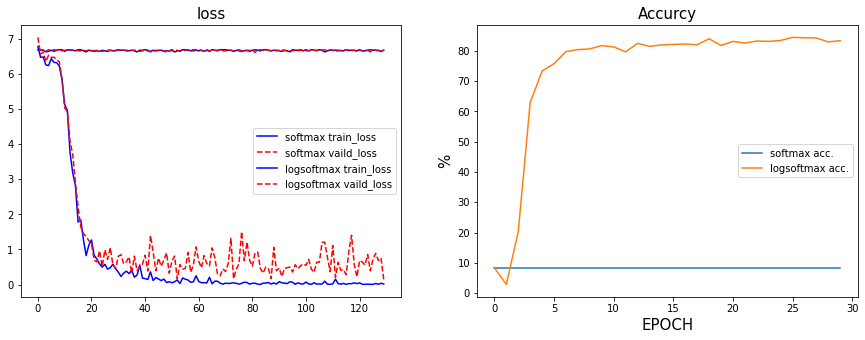

In [ ]:
# logsoftmax result
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_01, label = 'softmax train_loss', color = 'b')
plt.plot(valid_loss_01, label = 'softmax vaild_loss', color = 'r', linestyle="dashed")
plt.plot(train_loss_02, label = 'logsoftmax train_loss', color = 'b')
plt.plot(valid_loss_02, label = 'logsoftmax vaild_loss', color = 'r', linestyle="dashed")
plt.title('loss',size = 15)
plt.legend(fontsize = 10)
plt.subplot(1, 2, 2)
plt.plot(record_acc_01, label = 'softmax acc.')
plt.plot(record_acc_02, label = 'logsoftmax acc.')
plt.title('Accurcy', size = 15)
plt.ylabel('%', size = 15)
plt.xlabel('EPOCH', size = 15)
plt.legend(fontsize = 10)
print()
# 顏色繪錯 毫無變化的為softmax

In [ ]:
def Get_Pred_Acc_with_Train_02(model, data, count, shape = (64, 64)):
    with torch.no_grad():
        correct = 0
        IsGpu = False

        if torch.cuda.is_available() and str(next(model.parameters()).device) !='cpu':
            IsGpu = True
            
        for i ,(img, label) in enumerate(data):
            img = Batch_Image_Data(img, resize_shape = shape)
            # label == list 
            if IsGpu == True:
                img = img.cuda()
            pred = model(img)
            pred_value, pred_label = torch.max(pred, 1)
            
            if IsGpu == False:
                pred = pred_label.data.numpy()
            else:
                pred = pred_label.data.cpu().numpy()

            correct += (pred == np.array(label)).sum()  
            
        acc = 100*correct/count
        return acc
if __name__ == '__main__':
    print('get')
    # sample
    # test_data_set03 = MyDataset02(root = os.getcwd(), transforms = data_transform, 
    #                             tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
    # test_data_loader03 = torch.utils.data.DataLoader(dataset = test_data_set03, batch_size = 64, 
    #                                              shuffle = False, collate_fn = train_data_set.collate_fn) ##
    # model_03 = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax')
    # acc = Get_Pred_Acc_with_Train_02(model_03, test_data_loader03, len(test_data_set03))
    # print(acc)

get


In [ ]:
# dataset02


''' 
train & valid 
according the result 'activation func.' and 'shape change method'
compare with dataset method
'''
torch.cuda.empty_cache() # clean cache, use jupyter note have some cache on gpu memory after training
# get train & valid data
root = os.getcwd()
data_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_data_set03 = MyDataset02(root = os.getcwd(), transforms = data_transform)
valid_data_set03 = MyDataset02(root = os.getcwd(), transforms = data_transform, train=False) 

train_data_loader03 = torch.utils.data.DataLoader(dataset = train_data_set03, batch_size = 64, shuffle = True,
                                                  collate_fn = train_data_set.collate_fn)
valid_data_loader03 = torch.utils.data.DataLoader(dataset = valid_data_set03, batch_size = 64, shuffle = True,
                                                  collate_fn = train_data_set.collate_fn)

# get test data 
test_data_set03 = MyDataset02(root = os.getcwd(), transforms = data_transform, 
                                tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
test_data_loader03 = torch.utils.data.DataLoader(dataset = test_data_set03, batch_size = 64, 
                                                 shuffle = False, collate_fn = train_data_set.collate_fn) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 30
LR = 0.001
loss_CE = nn.CrossEntropyLoss()
model_03 = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax') #
optimizer_03 = torch.optim.Adam(model_03.parameters(), lr = LR)

if torch.cuda.is_available():
    model_03 = model_03.to(device)

train_loss_03, valid_loss_03 , record_acc_03 = [], [], []
index = 0

for epoch in range(EPOCH):
    for i, (data, label) in enumerate(train_data_loader03):
        
        data = Batch_Image_Data(data, resize_shape = (64, 64))
        label = torch.LongTensor(label) ## list to tensor
        optimizer_03.zero_grad()

        if torch.cuda.is_available():
            data = data.to(device)
            label = label.to(device)

        #
        out_03 = model_03(data)
        t_loss_03 = loss_CE(out_03, label)
        t_loss_03.backward()
        optimizer_03.step()
        if index % 200 == 0:
            # ===== get valid loss =====
            with torch.no_grad():
                # randn get valid data to record loss
                for i , (data, label) in enumerate(valid_data_loader03):
                    
                    data = Batch_Image_Data(data, resize_shape = (64, 64))
                    label = torch.LongTensor(label) ## list to tensor2
                    if torch.cuda.is_available():
                        data = data.to(device)
                        label = label.to(device)
                        
                    out_03 = model_03(data)
                    v_loss_03 = loss_CE(out_03, label)
                    break
            # ===== record loss =====
            train_loss_03.append(t_loss_03.item())
            valid_loss_03.append(v_loss_03.item())
            
        index += 1
    with torch.no_grad():
        print('epoch[{}], train_loss:{:.5f}, valid_loss:{:.5f}, '.format(epoch+1, 
                                        t_loss_03.item(), v_loss_03.item()))
        acc03 = Get_Pred_Acc_with_Train_02(model_03, test_data_loader03, len(test_data_set03))
        record_acc_03.append(acc03)
        print('dataset02 Accurcy :', acc03)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


epoch[1], train_loss:6.62675, valid_loss:6.55299, 
dataset02 Accurcy : 8.352337514253136
epoch[2], train_loss:6.64069, valid_loss:6.39161, 
dataset02 Accurcy : 8.352337514253136
epoch[3], train_loss:4.51879, valid_loss:5.72739, 
dataset02 Accurcy : 2.5513112884834666
epoch[4], train_loss:1.73694, valid_loss:1.81346, 
dataset02 Accurcy : 41.88996579247434
epoch[5], train_loss:0.13721, valid_loss:0.98420, 
dataset02 Accurcy : 68.77137970353478
epoch[6], train_loss:0.35600, valid_loss:0.75041, 
dataset02 Accurcy : 75.21379703534778
epoch[7], train_loss:0.16988, valid_loss:0.53659, 
dataset02 Accurcy : 77.16647662485747
epoch[8], train_loss:0.21519, valid_loss:0.82184, 
dataset02 Accurcy : 79.53249714937286
epoch[9], train_loss:0.01645, valid_loss:0.43881, 
dataset02 Accurcy : 80.30216647662486
epoch[10], train_loss:0.18238, valid_loss:0.58689, 
dataset02 Accurcy : 81.96978335233752
epoch[11], train_loss:0.05093, valid_loss:0.71487, 
dataset02 Accurcy : 80.13112884834663
epoch[12], train_l

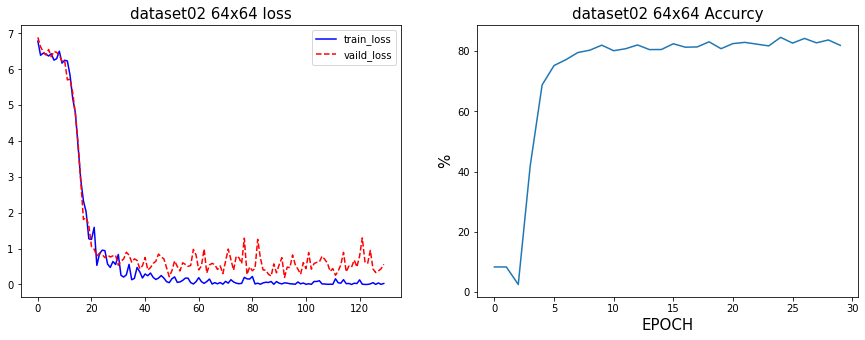

In [ ]:
# dataset2 result 64x64 
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_03, label = 'train_loss', color = 'b')
plt.plot(valid_loss_03, label = 'vaild_loss', color = 'r', linestyle="dashed")
plt.title('dataset02 64x64 loss',size = 15)
plt.legend(fontsize = 10)
plt.subplot(1, 2, 2)
plt.plot(record_acc_03)
plt.title('dataset02 64x64 Accurcy', size = 15)
plt.ylabel('%', size = 15)
plt.xlabel('EPOCH', size = 15)
print()

In [ ]:
# dataset2 result 96x96 
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_03, label = 'train_loss')
plt.plot(valid_loss_03, label = 'vaild_loss')
plt.title('dataset02 96x96 loss',size = 15)
plt.legend(fontsize = 10)
plt.subplot(1, 2, 2)
plt.plot(record_acc_03)
plt.title('dataset02 64x64 Accurcy', size = 15)
plt.ylabel('%', size = 15)
plt.xlabel('EPOCH', size = 15)
print()

In [ ]:
# pred test, only show competition one day data , because the dataset is private
# 只提供某一天的比賽數據當做model參數的預測證明


In [ ]:
# ==================附註========================
# === Resize VS Padding ===
# === Padding VS Interpolate 96x96 ===

train_data_Resize : 55043


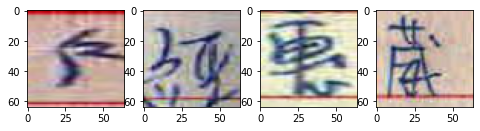

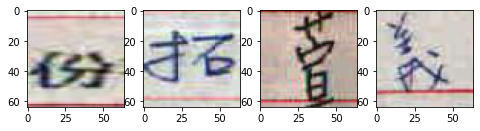

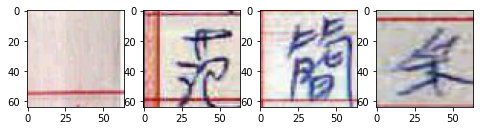

In [33]:
class Dataset_Resize(torch.utils.data.Dataset):
    def __init__(self, root,tab_file = 'basic_image_tab.csv', transforms = None, train = True,
                 scale = 0.8, shape = (64, 64), test = False):
        super().__init__()
        
        df = pd.read_csv(root + '/'+ tab_file , encoding = 'big5')
        imgs = df['img_name'].values.tolist()
        labels = df['img_token'].values.tolist()
        self.imgs = imgs
        self.labels = labels
        
        self.root = os.path.join(root, 'ImageDataset', 'training_set')
        if test != False:
            self.root = os.path.join(root, 'ImageDataset', 'testing_set', test)
        self.train = train
        self.transforms = transforms
        self.count = int(len(self.imgs)*scale)
        self.shape = shape
        
        
    def __len__(self):
        if self.train == True:
            return self.count
        else :
            return len(self.imgs) - self.count
        
    def __getitem__(self, index):
        
        
        if self.train == True:
            img_path = os.path.join(self.root , self.imgs[index])
            img = Image.open(img_path)
            label = self.labels[index]
        else:
            img_path = os.path.join(self.root , self.imgs[self.count+index])
            img = Image.open(img_path)
            label = self.labels[self.count+index]
            
        if self.transforms != None:
            img = self.transforms(img)
        else:
            transform_data = torchvision.transforms.Compose([
                torchvision.transforms.Resize((self.shape)),
                torchvision.transforms.ToTensor()
            ])
            img = transform_data(img)
        return img, label
if __name__ == '__main__':
    
    root = os.getcwd()
    train_data_Resize = Dataset_Resize(root)
    print('train_data_Resize :', len(train_data_Resize))
    data_loader = torch.utils.data.DataLoader(dataset = train_data_Resize, batch_size = 4,shuffle = False)
    
    for i, (data, label) in enumerate(data_loader):

        index = 0
        plt.figure(figsize =(8,4))
        for sample in data:
            
            plt.subplot(1, 4, index+1)
            plt.imshow(torchvision.transforms.ToPILImage()(sample))
            index += 1
        if i == 2:
            break    

In [34]:
# PS:
''' 
train & valid 
compare with 'Resize method' about transforms.Resize and transforms.Pad
'''
torch.cuda.empty_cache() # clean cache, use jupyter note have some cache on gpu memory after training
# get data
SHAPE = (64,64)
root = os.getcwd()
# Padding Data
train_data_set_pad = MyDataset01(root, shape = SHAPE)
valid_data_set_pad = MyDataset01(root, shape = SHAPE, train=False)

train_data_loader_pad = torch.utils.data.DataLoader(dataset = train_data_set_pad, batch_size = 32, shuffle = True)
valid_data_loader_pad = torch.utils.data.DataLoader(dataset = valid_data_set_pad, batch_size = 64, shuffle = True)
 
test_data_pad = MyDataset01(root, tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
test_dataloader_pad = torch.utils.data.DataLoader(dataset = test_data_pad, batch_size = 64, shuffle = False)
# Resize Data
train_data_set_resize = Dataset_Resize(root, shape = SHAPE)
valid_data_set_resize = Dataset_Resize(root, shape = SHAPE, train=False)

train_data_loader_resize = torch.utils.data.DataLoader(dataset = train_data_set_resize, batch_size = 32, shuffle = True)
valid_data_loader_resize = torch.utils.data.DataLoader(dataset = valid_data_set_resize, batch_size = 64, shuffle = True)
 
test_data_resize = Dataset_Resize(root, tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
test_dataloader_resize = torch.utils.data.DataLoader(dataset = test_data_resize, batch_size = 64, shuffle = False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 30
LR = 0.001
loss_CE = nn.CrossEntropyLoss()
model_Pad = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax')
model_Resize = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax')

optimizer_Pad = torch.optim.Adam(model_Pad.parameters(), lr = LR)
optimizer_Resize = torch.optim.Adam(model_Resize.parameters(), lr = LR)
if torch.cuda.is_available():
    model_Resize = model_Resize.to(device)
    model_Pad = model_Pad.to(device)
    

train_loss_Pad, valid_loss_Pad , record_acc_Pad = [], [], []
train_loss_Resize, valid_loss_Resize , record_acc_Resize = [], [], []

index_pad = 0
index_resize = 0
for epoch in range(EPOCH):
    # train Padding dataset
    for i, (data, label) in enumerate(train_data_loader_pad):
        optimizer_Pad.zero_grad()

        if torch.cuda.is_available():
            data = data.to(device)
            label = label.to(device)
        #
        out_pad = model_Pad(data)
        t_loss_pad = loss_CE(out_pad, label)
        t_loss_pad.backward()
        optimizer_Pad.step()
        if index_pad % 200 == 0:
            # ===== get valid loss =====
            with torch.no_grad():
                # randn get valid data to record loss
                for i , (data, label) in enumerate(valid_data_loader_resize):
                    
                    if torch.cuda.is_available():
                        data = data.to(device)
                        label = label.to(device)
                        
                    out_pad = model_Pad(data)
                    v_loss_pad = loss_CE(out_pad, label)
                    break
            # ===== record loss =====
            train_loss_Pad.append(t_loss_pad.item())
            valid_loss_Pad.append(v_loss_pad.item())
        index_pad += 1
        
    # train Resize dataset
    for i, (data, label) in enumerate(train_data_loader_resize):
        optimizer_Resize.zero_grad()
        if torch.cuda.is_available():
            data = data.to(device)
            label = label.to(device)
            
        out_resize = model_Resize(data)
        t_loss_resize = loss_CE(out_resize, label)
        t_loss_resize.backward()
        optimizer_Resize.step()
        if index_resize % 200 == 0:
            # ===== get valid loss =====
            with torch.no_grad():
                # randn get valid data to record loss
                for i , (data, label) in enumerate(valid_data_loader_resize):
                    if torch.cuda.is_available():
                        data = data.to(device)
                        label = label.to(device)
                    out_resize = model_Resize(data)
                    v_loss_resize = loss_CE(out_resize, label)
                    break
                # ===== record loss =====
            train_loss_Resize.append(t_loss_resize.item())
            valid_loss_Resize.append(v_loss_resize.item())
        index_resize += 1
        
    with torch.no_grad():
        acc_pad = Get_Pred_Acc_with_Train(model_Pad, test_dataloader_pad, len(test_data_pad))
        record_acc_Pad.append(acc_pad)
        
        acc_resize = Get_Pred_Acc_with_Train(model_Resize, test_dataloader_resize, len(test_data_resize))
        record_acc_Resize.append(acc_resize)
        print('epoch [{}] > Padding : Acc:{:.5f} ; Resize : Acc:{:.5f}'.format(epoch+1, acc_pad, acc_resize))
        print('======')
    


epoch [1] > Padding : Acc:8.35234 ; Resize : Acc:8.35234
epoch [2] > Padding : Acc:4.21893 ; Resize : Acc:7.61117
epoch [3] > Padding : Acc:57.58267 ; Resize : Acc:11.11745
epoch [4] > Padding : Acc:74.52965 ; Resize : Acc:62.34322
epoch [5] > Padding : Acc:78.39225 ; Resize : Acc:74.71494
epoch [6] > Padding : Acc:79.84607 ; Resize : Acc:79.07640
epoch [7] > Padding : Acc:80.85804 ; Resize : Acc:79.68928
epoch [8] > Padding : Acc:82.49715 ; Resize : Acc:79.67503
epoch [9] > Padding : Acc:81.85576 ; Resize : Acc:80.28791
epoch [10] > Padding : Acc:82.52566 ; Resize : Acc:79.87457
epoch [11] > Padding : Acc:83.45211 ; Resize : Acc:81.37115
epoch [12] > Padding : Acc:82.12657 ; Resize : Acc:81.54219
epoch [13] > Padding : Acc:82.38312 ; Resize : Acc:81.98404
epoch [14] > Padding : Acc:84.03649 ; Resize : Acc:82.38312
epoch [15] > Padding : Acc:83.36659 ; Resize : Acc:82.45439
epoch [16] > Padding : Acc:83.70867 ; Resize : Acc:82.82497
epoch [17] > Padding : Acc:83.86545 ; Resize : Acc:82

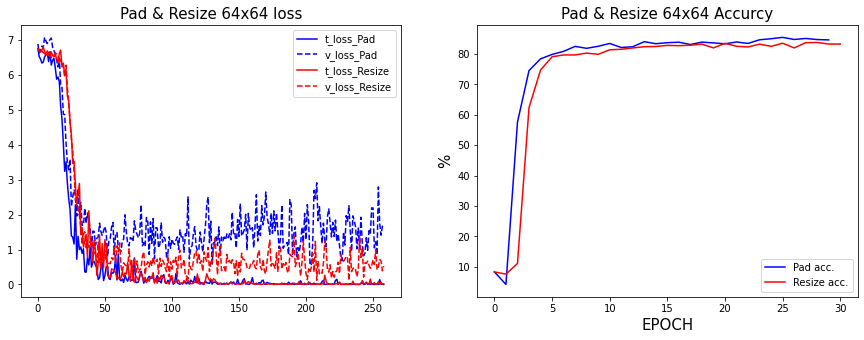

In [36]:
# dataset2 result 96x96 
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_Pad, label = 't_loss_Pad', color = 'b')
plt.plot(valid_loss_Pad, label = 'v_loss_Pad', color = 'b', linestyle="dashed")
plt.plot(train_loss_Resize, label = 't_loss_Resize', color = 'r')
plt.plot(valid_loss_Resize, label = 'v_loss_Resize', color = 'r', linestyle="dashed")
plt.title('Pad & Resize 64x64 loss',size = 15)
plt.legend(fontsize = 10)
plt.subplot(1, 2, 2)
plt.plot(record_acc_Pad, label='Pad acc.', color='b')
plt.plot(record_acc_Resize, label='Resize acc.', color='r')
plt.title('Pad & Resize 64x64 Accurcy', size = 15)
plt.ylabel('%', size = 15)
plt.xlabel('EPOCH', size = 15)
plt.legend(fontsize = 10)
# Padding acc. > Resize acc. 
print()

In [ ]:
'''
=== Padding VS Interpolate 96x96 ===
'''
torch.cuda.empty_cache()
SHAPE = (96, 96)
root = os.getcwd()
# Padding data
train_data_set_pad = MyDataset01(root, shape = SHAPE)
valid_data_set_pad = MyDataset01(root, shape = SHAPE, train=False)

train_data_loader_pad = torch.utils.data.DataLoader(dataset = train_data_set_pad, batch_size = 64, shuffle = True)
valid_data_loader_pad = torch.utils.data.DataLoader(dataset = valid_data_set_pad, batch_size = 64, shuffle = True)
 
test_data_pad = MyDataset01(root, tab_file = 'test_image0616_tab.csv', shape = SHAPE, 
                            scale = 1, test = 'test_stage_data_0616')
test_dataloader_pad = torch.utils.data.DataLoader(dataset = test_data_pad, batch_size = 64, shuffle = False)
# Interpolate data
data_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_data_set_interpolate = MyDataset02(root = os.getcwd(), transforms = data_transform)
valid_data_set_interpolate = MyDataset02(root = os.getcwd(), transforms = data_transform, train=False) 

train_data_loader_interpolate = torch.utils.data.DataLoader(dataset = train_data_set_interpolate, 
                                    batch_size = 64, shuffle = True,collate_fn = train_data_set.collate_fn)
valid_data_loader_interpolate = torch.utils.data.DataLoader(dataset = valid_data_set_interpolate, 
                                    batch_size = 64, shuffle = True,collate_fn = train_data_set.collate_fn)

test_data_set_interpolate = MyDataset02(root = os.getcwd(), transforms = data_transform, 
                                tab_file = 'test_image0616_tab.csv', scale = 1, test = 'test_stage_data_0616')
test_data_loader_interpolate = torch.utils.data.DataLoader(dataset = test_data_set_interpolate, batch_size = 64, 
                                                 shuffle = False, collate_fn = train_data_set.collate_fn) 

# get model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 30
LR = 0.001
loss_CE = nn.CrossEntropyLoss()
model_pad = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax')
optim_pad = torch.optim.Adam(model_pad.parameters(), lr = LR)
model_interpolate = base_ResNet(Base_block_GN, last_layer = 'Logsoftmax')
optim_interpolate = torch.optim.Adam(model_interpolate.parameters(), lr = LR)

if torch.cuda.is_available():
    model_pad = model_pad.to(device)
    model_interpolate = model_interpolate.to(device)
    
train_loss_pad, valid_loss_pad , record_acc_pad = [], [], []
index_pad = 0
train_loss_interpolate, valid_loss_interpolate , record_acc_interpolate = [], [], []
index_interpolate = 0

# training & testing
for epoch in range(EPOCH):
    # Padding Data
    for i, (data, label) in enumerate(train_data_loader_pad):
        optim_pad.zero_grad()
        if torch.cuda.is_available():
            data = data.to(device)
            label = label.to(device)
        out_pad = model_pad(data)
        t_loss_pad = loss_CE(out_pad, label)
        t_loss_pad.backward()
        optim_pad.step()
        if index_pad % 200 == 0:
            for i ,(data, label) in enumerate(valid_data_loader_pad):
                if torch.cuda.is_available():
                    data = data.to(device)
                    label = label.to(device)
                out_pad = model_pad(data)
                v_loss_pad = loss_CE(out_pad, label)
                break
            # === record loss
            train_loss_pad.append(t_loss_pad.item())
            valid_loss_pad.append(v_loss_pad.item())
            
        index_pad += 1
        
    # Interpolate Data
    for i ,(data, label) in enumerate(train_data_loader_interpolate):
        data = Batch_Image_Data(data, resize_shape = SHAPE)
        label = torch.LongTensor(label)
        optim_interpolate.zero_grad()
        if torch.cuda.is_available():
            data = data.to(device)
            label = label.to(device)
        out_interpolate = model_interpolate(data)
        t_loss_interpolate = loss_CE(out_interpolate, label)
        t_loss_interpolate.backward()
        optim_interpolate.step()
        if index_interpolate % 200 == 0:
            for i ,(data, label) in enumerate(valid_data_loader_interpolate):
                data = Batch_Image_Data(data, resize_shape = SHAPE)
                label = torch.LongTensor(label)
                if torch.cuda.is_available():
                    data = data.to(device)
                    label = label.to(device)
                out_interpolate = model_interpolate(data)
                v_loss_interpolate = loss_CE(out_interpolate, label)
                break
            # ====== record loss
            train_loss_interpolate.append(t_loss_interpolate.item())
            valid_loss_interpolate.append(v_loss_interpolate.item())
        
        index_interpolate += 1
    # === get every epoch acc.
    with torch.no_grad():
        # Padding Accuracy
        acc_pad = Get_Pred_Acc_with_Train(model_pad, test_dataloader_pad, len(test_data_pad))
        record_acc_pad.append(acc_pad)
        
        # Interpolate Accuracy
        acc_interpolate = Get_Pred_Acc_with_Train_02(model_interpolate, 
                            test_data_loader_interpolate, len(test_data_set_interpolate), shape = SHAPE)
        record_acc_interpolate.append(acc_interpolate)
        print('epoch[{}], Acc >> Padding:{:.3f} ; Interpolate:{:.3f}'.format(epoch+1, acc_pad, acc_interpolate))

epoch[1], Acc >> Padding:8.253 ; Interpolate:8.352
epoch[2], Acc >> Padding:8.310 ; Interpolate:3.178
epoch[3], Acc >> Padding:5.031 ; Interpolate:10.989
epoch[4], Acc >> Padding:5.245 ; Interpolate:53.920
epoch[5], Acc >> Padding:54.304 ; Interpolate:71.323
epoch[6], Acc >> Padding:70.966 ; Interpolate:75.912
epoch[7], Acc >> Padding:75.855 ; Interpolate:78.962
epoch[8], Acc >> Padding:77.608 ; Interpolate:81.499
epoch[9], Acc >> Padding:80.359 ; Interpolate:81.956
epoch[10], Acc >> Padding:80.801 ; Interpolate:81.870
epoch[11], Acc >> Padding:81.756 ; Interpolate:83.124
epoch[12], Acc >> Padding:82.925 ; Interpolate:82.711
epoch[13], Acc >> Padding:83.153 ; Interpolate:83.409
epoch[14], Acc >> Padding:82.811 ; Interpolate:83.139
epoch[15], Acc >> Padding:82.839 ; Interpolate:83.523
epoch[16], Acc >> Padding:82.055 ; Interpolate:81.015
epoch[17], Acc >> Padding:83.210 ; Interpolate:83.937
epoch[18], Acc >> Padding:82.155 ; Interpolate:82.497
epoch[19], Acc >> Padding:83.452 ; Interpol

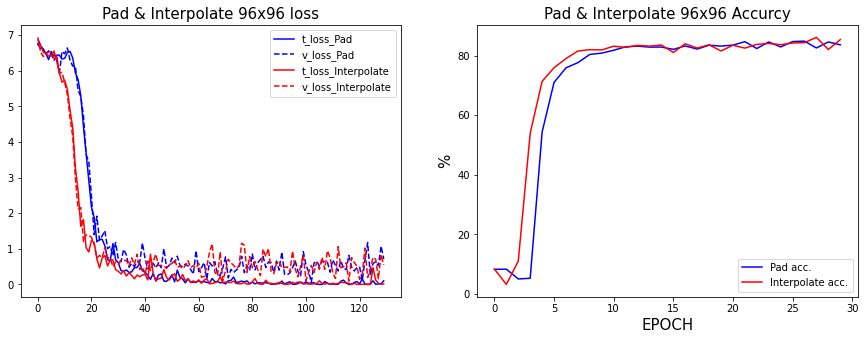

In [ ]:
# Pad & Interpolate result 96x96 
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_pad, label = 't_loss_Pad', color = 'b')
plt.plot(valid_loss_pad, label = 'v_loss_Pad', color = 'b', linestyle="dashed")
plt.plot(train_loss_interpolate, label = 't_loss_Interpolate', color = 'r')
plt.plot(valid_loss_interpolate, label = 'v_loss_Interpolate', color = 'r', linestyle="dashed")
plt.title('Pad & Interpolate 96x96 loss',size = 15)
plt.legend(fontsize = 10)
plt.subplot(1, 2, 2)
plt.plot(record_acc_pad, label='Pad acc.', color='b')
plt.plot(record_acc_interpolate, label='Interpolate acc.', color='r')
plt.title('Pad & Interpolate 96x96 Accurcy', size = 15)
plt.ylabel('%', size = 15)
plt.xlabel('EPOCH', size = 15)
plt.legend(fontsize = 10)
# 當前結果只表示插值法更快收斂，但並無明顯的預測差異，再後續驗證會加上attention 機制
print()